## Neural Network - Butterfly Predictions

##### Owen Kroeger and Teddy Coon
##### CST-435
##### Video Links:
[Owen Kroeger](https://drive.google.com/file/d/1qvjE7XJYOxUfabPcwjAF9NmCyNCpIMgo/view?usp=sharing)

Teddy Coon - https://www.loom.com/share/1fa3275439ee4c948bbd45e5f0639b5f 

##### Raw Code:
[GitHub Code](https://github.com/oskroeger/CST-435-Neural/blob/main/Projects/NeuralNetwork/NeuralNetwork.py)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2024-10-06 23:07:44.741966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 23:07:44.756528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 23:07:44.760659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 23:07:44.771574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 23:07:45.611790: W tensorflow/compiler/tf2

This code is just the imports for the project.

In [2]:
# ---------------------------------------
# Load and prepare the dataset
# ---------------------------------------
# Load the CSV files containing image filenames and labels
train_df = pd.read_csv('Training_set.csv')
test_df = pd.read_csv('Testing_set.csv')

# Set the directories containing the images
train_dir = 'train/'
test_dir = 'test/'


The code above loads training and testing datasets from CSV files containing image filenames and labels into Pandas DataFrames (train_df and test_df). It also defines the directories (train/ and test/) where the corresponding image files are stored. The training set is used to train the model, while the test set is for evaluation. This setup links image files to their labels, preparing the data for a machine learning model, likely for an image classification task.

In [3]:
# ---------------------------------------
# Preprocess images for training and testing
# ---------------------------------------
# Data augmentation and rescaling for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale images to [0, 1] range
    horizontal_flip=True       # Simple augmentation by flipping images horizontally
)

# Rescale the test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training data with reduced image size (96x96) and batch size of 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),      # Reduced image size for faster training
    batch_size=32,
    class_mode='categorical',  # Categorical labels for multi-class classification
    shuffle=True
)


Found 6499 validated image filenames belonging to 75 classes.


This code preprocesses images for both training and testing using ImageDataGenerator. For training, images are rescaled to the [0, 1] range using rescale=1./255 and augmented by horizontally flipping them to increase dataset variability. For both training and testing, images are resized to 96x96 pixels to reduce computational load. The training images are shuffled and processed in batches of 32, with categorical labels for multi-class classification. For testing, images are only rescaled and not shuffled, with no labels provided since they will be used for predictions. This preprocessing ensures consistency and optimizes model performance.

In [4]:
# Generate test data (without labels) for prediction
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,                # No labels needed for the test set
    target_size=(96, 96),      # Match training image size
    batch_size=32,
    class_mode=None,
    shuffle=False              # Don't shuffle to maintain order in prediction
)

Found 2786 validated image filenames.


The test data is rescaled to the [0, 1] range, resized to 96x96 pixels, processed in batches of 32, and not shuffled, without any labels provided.

In [5]:
# ---------------------------------------
# Initialize the pre-trained MobileNetV2 CNN
# ---------------------------------------
# MobileNetV2 model, pretrained on ImageNet, used as the base
# The first layer (Conv1) has the following arguments:
# - Filters: 24
# - Kernel size: (3, 3)
# - Padding: 'same'
# - Activation: ReLU
# - Input shape: (96, 96, 3)
# Global Average Pooling is applied as the pooling operation
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3), alpha=0.75)

# Freeze the base model's convolutional layers
base_model.trainable = False  # Freeze to only train the top layers for faster training

I0000 00:00:1728278296.904567   46870 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-06 22:18:16.944998: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


This section initializes a MobileNetV2 model, pre-trained on ImageNet, as the base for transfer learning. The model is used without the top classification layers (include_top=False) and is adapted to an input size of 96x96 pixels with 3 color channels. The model’s convolutional layers are frozen (trainable=False) to prevent them from being updated during training, allowing only the new top layers to be trained. This speeds up training by leveraging the pre-learned features from ImageNet.

In [6]:
# ---------------------------------------
# Build the complete model
# ---------------------------------------
# Add the base model, global pooling, and fully connected layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),    # Global pooling to down-sample features
    layers.Dense(128, activation='relu'),  # Fully connected layer (ReLU activation)
    layers.Dense(75, activation='softmax')  # Output layer (Softmax for multi-class classification)
])

This part of the code builds a complete image classification model by combining the pre-trained MobileNetV2 base with additional layers. The GlobalAveragePooling2D layer reduces the spatial dimensions of the feature maps, followed by a fully connected Dense layer with 128 units and ReLU activation to learn complex patterns. The final Dense layer with softmax activation outputs probabilities for each of the 75 possible classes, making it suitable for multi-class classification. The MobileNetV2 base is frozen to leverage pre-learned features, while only the added layers are trained.

In [7]:
# ---------------------------------------
# Compile the model
# ---------------------------------------
# Compile using categorical crossentropy, Adam optimizer, and accuracy as the metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---------------------------------------
# Train the model with early stopping
# ---------------------------------------
# Early stopping will monitor accuracy, and stop training after 2 epochs of no improvement
early_stopping = EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)

# Train the model for up to 50 epochs but stop early if accuracy is high enough
history = model.fit(
    train_generator,
    epochs=50,  # Train up to 50 epochs
    callbacks=[early_stopping],  # Stop early if accuracy plateaus
    verbose=1
)

if len(history.history['accuracy']) < 50:
    print(f"Training stopped early after {len(history.history['accuracy'])} epochs because accuracy plateaued.")

# ---------------------------------------
# Predict on the test set
# ---------------------------------------
# Predict the class labels for the test set
test_predictions = model.predict(test_generator)
predicted_labels = tf.argmax(test_predictions, axis=1).numpy()  # Get the class index with the highest score

# Map predicted class indices back to class names
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
predicted_class_names = [label_map[label] for label in predicted_labels]

# Save predictions to a CSV file
test_df['predicted_label'] = predicted_class_names
test_df.to_csv('submission.csv', columns=['filename', 'predicted_label'], index=False)

print("Predictions saved to submission.csv.")


Epoch 1/50


/home/oskroeger/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.3192 - loss: 3.0047
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.8241 - loss: 0.6418
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.9071 - loss: 0.3488
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.9509 - loss: 0.1992
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.9621 - loss: 0.1568
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 179ms/step - accuracy: 0.9787 - loss: 0.1013
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.9836 - loss: 0.0782
Epoch 8/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.9890 - loss: 0.0588
Epoch 9/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.9902 - loss: 0.0499
Epoch 10/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.9898 - loss: 0.0491
Epoch 11/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.9943 - loss: 0.0335
Epoch 12/50
204/204 ━━━━━━━━━━

This section of the code compiles, trains, and uses the model for prediction. The model is compiled with the Adam optimizer, categorical crossentropy as the loss function for multi-class classification, and accuracy as the performance metric. Early stopping is configured to monitor accuracy and stop training if no improvement is observed for 2 epochs, restoring the best weights to avoid overfitting. The model is trained for a maximum of 50 epochs, but early stopping can halt training if accuracy plateaus. After training, the model predicts class labels for the test set. These predictions are generated using predict, and the highest-scoring class for each image is extracted using argmax. The predicted class indices are then mapped back to their class names using a label mapping dictionary created from the training data. Finally, the test predictions are saved into a CSV file (submission.csv), which contains the filenames and the predicted class labels for each test image.

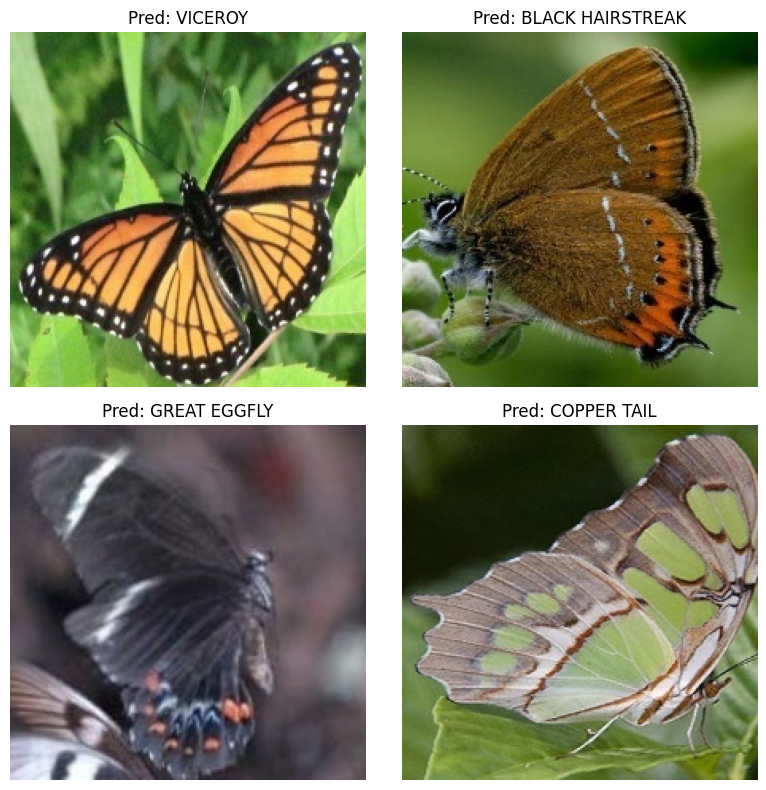

In [8]:
# ---------------------------------------
# Visualize Random Test Predictions
# ---------------------------------------
# Function to display 4 random test images along with their predicted labels
import random
def display_random_predictions(test_df, test_dir, predicted_class_names):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Create a 2x2 grid for the images
    axes = axes.ravel()  # Flatten the axes array for easier indexing

    # Select 4 random images from the test dataset
    random_indices = random.sample(range(len(test_df)), 4)

    for i, idx in enumerate(random_indices):
        img_path = os.path.join(test_dir, test_df['filename'].iloc[idx])  # Get the image path
        
        # Load the original image (without resizing)
        original_img = Image.open(img_path)
        
        # Display the original image in the grid
        axes[i].imshow(original_img)
        axes[i].axis('off')  # Hide axis for a cleaner display
        axes[i].set_title(f"Pred: {predicted_class_names[idx]}")  # Show predicted class

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# Display 4 random test images and their predictions
display_random_predictions(test_df, test_dir, predicted_class_names)

This code defines a function, display_random_predictions, that visualizes four random test images along with their predicted labels. It creates a 2x2 grid using Matplotlib for displaying the images. The function randomly selects four images from the test dataset (test_df), loads them from the test_dir using PIL (Image.open()), and displays each image in the grid. For each image, the corresponding predicted class (from predicted_class_names) is displayed as the title above the image. The axes are turned off to make the display cleaner, and plt.tight_layout() is used to adjust spacing between images. Finally, the images are shown using plt.show().

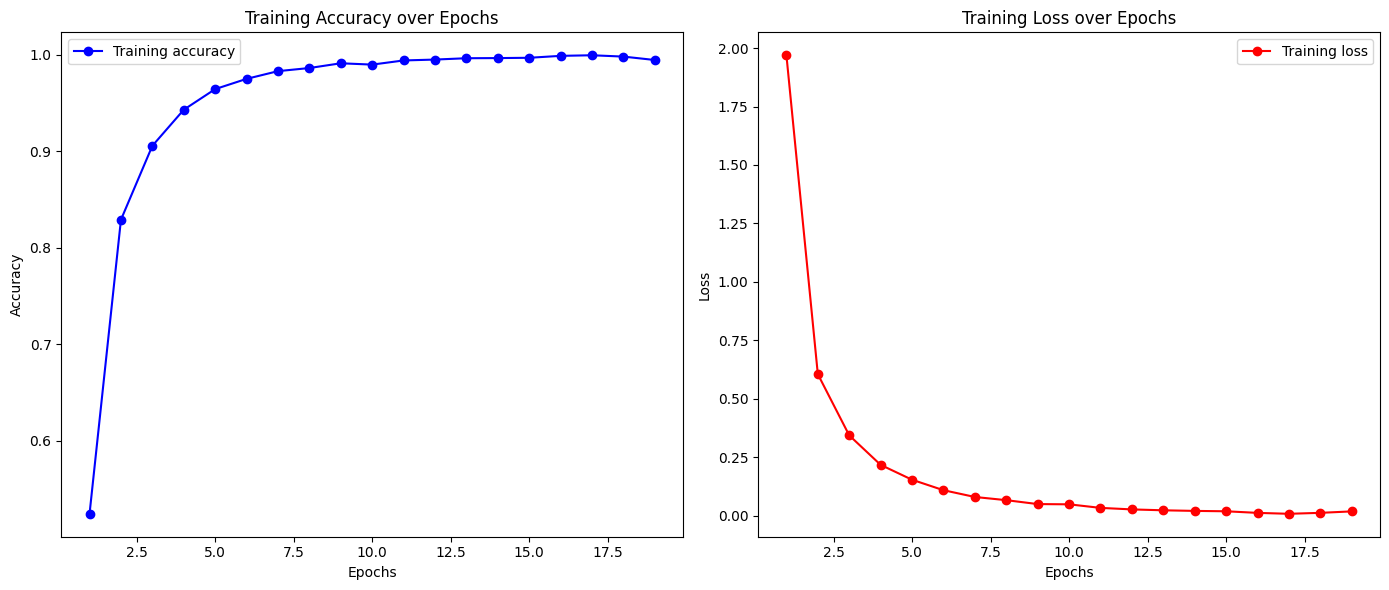

In [9]:
# Plot accuracy and loss over epochs
def plot_accuracy_and_loss(history):
    # Get the values from the history object
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(accuracy) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function after training
plot_accuracy_and_loss(history)

This code block plots the accuracy vs loss on two separate graphs side by side, allowing us to see the comparison.